# Data pipeline

This file:

1.  Reads in data
2.  Conducts Feature engineering
3.  Conducts Exploratory data analysis
4.  Conducts additional analysis
5.  Extracts data

The notebook reads in the LendingClub data from csv format and conducts EDA and feature engineering.

The output form the file is a csv file with cleaned data that feeds into the subsequent analytical models

Occasional switches to speed up the process are included.

In [ ]:
############################################################################################
# READS IN THE DATA and does feature engingeering - out to pipeline
# added the snippet for the util_balance, removed the home_ownership/rent/own-- but kept home_ownership
# removed all purposes -- but keept purpose
# NEEDS to run initially to get the data in the right shape with the right variables.
# code on pep-8
############################################################################################
# Peter Went, 2019

## Reads in data

Importing core libraries for the process and setting some standard switches for the outputs

By default the graphs are large.  

In [2]:
#import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# graph and picture formats
plt.rc("font", size=16)
plt.rcParams["figure.figsize"] = (10, 10)  # sets size
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize': (10, 10)})  # sets size

In [8]:
# Path for internal reference for the location of the LendingClub data.
# Should be changes to fit your needs
# --------
!cd /Users/alderaan/Downloads/LendingClub_data

#initiates a dictionary called 'data' to save manipulated datafiles as csv
!mkdir -p data

This cell reads in the data. This version includes the first 110 columns of data.  The existing data set contains over 150 columns.  For data dictionary see [the lending club website](https://resources.lendingclub.com/LCDataDictionary.xlsx).  Note the page reference may change.

In [14]:
# Actual read in based on stackoverflow (20906474)
# Skips row = 0 (index) because of the source reference information on that row.
# variable col_num can be changed to adjust the number of columns to read in.
# Fewer columns rapdily improve the throughput and the speed.
# --------
col_num = pd.Series(range(0, 101)).to_list()

# Path for internal reference for the location of the LendingClub data.
# Should be changes to fit your needs
path = r'/Users/alderaan/Downloads/LendingClub_data/'

# read path for list of files
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(
    f, skiprows=1, usecols=col_num, low_memory=False) for f in all_files)
file_in = pd.concat(df_from_each_file, ignore_index=True)

#this switch samples the dataset to approx 20k observations --> reduces run time considerably.
#concatenated_df = file_in.sample(frac=0.01) 
concatenated_df = file_in

# --------
# To speeed up the procecss read in only one file in the directory.
# Can be used to troubleshoot.
#concatenated_df = pd.read_csv('LoanStats3b_securev1.csv', skiprows = 1, usecols = keep_col)
# --------

## Exploratory data analysis
There are a number of variables that need to be assigned the right data type and coerce some gentle feature engineering.

New variables are:
- `vintage` which is the year the loan was issued. Can be used to control for changing underwriting standards.
- `last_pmt_year` which is the payoff or default year for the loan. Can be biased because the variable may include loans on repayment plans.
- `CREDIT_HISTORY` is the number of years since the first record on the credit reporting file. A proxy to infer age (and 20 years to the credit history to get approximate age)


In [15]:
# Featuring engineering vintage and payoff-time
# Extracting years
concatenated_df['issue_d'] = pd.to_datetime(concatenated_df['issue_d'])
concatenated_df['vintage'] = concatenated_df['issue_d'].dt.year

concatenated_df['last_pymnt_d'] = pd.to_datetime(
    concatenated_df['last_pymnt_d'])
concatenated_df['last_pmt_year'] = concatenated_df['last_pymnt_d'].dt.year

concatenated_df['earliest_cr_line'] = pd.to_datetime(
    concatenated_df['earliest_cr_line'])
concatenated_df['earliest_cr_line'] = concatenated_df['earliest_cr_line'].dt.year

concatenated_df['CREDIT_HISTORY'] = concatenated_df['vintage'] - 
    concatenated_df['earliest_cr_line']

### Vintage - year loan issued
Distribution of the years the loans were issued.  Captures the significant increase in underwriting after 2014.  We could question whether the underwriting standards have also changed to sustain that growth.  Worth exploring further.

In [16]:
concatenated_df['vintage'].describe()

count    2.376343e+06
mean     2.016011e+03
std      1.874658e+00
min      2.007000e+03
25%      2.015000e+03
50%      2.016000e+03
75%      2.018000e+03
max      2.019000e+03
Name: vintage, dtype: float64

Text(0, 0.5, 'Number of loans')

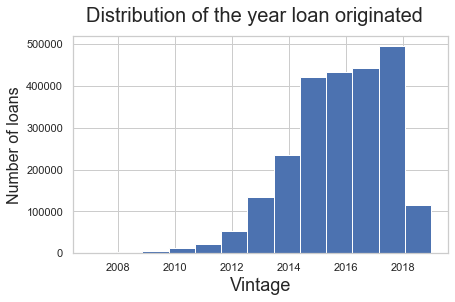

In [17]:
# bins set at 13.  First loan in 2007 and last loan in 2019.  That's 13 years, folks!
concatenated_df['vintage'].hist(bins=13)
plt.suptitle('Distribution of the year loan originated', fontsize=20)
plt.xlabel('Vintage', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

### Loan amount
Distribution of loan sizes.  Captures the tendency of even thousands and an unexpectedly large batch of loans of USD 40k. _Worth exploring further_, particularly the segment under $1,000 to better understand more consumptive behavior that can be more relevant here.

In [18]:
concatenated_df['loan_amnt'].describe()

count    2.376343e+06
mean     1.512600e+04
std      9.256783e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.300000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

Text(0, 0.5, 'Number of loans')

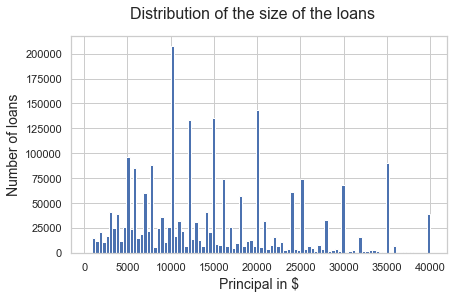

In [19]:
concatenated_df['loan_amnt'].hist(bins=100)
plt.suptitle('Distribution of the size of the loans', fontsize=16)
plt.xlabel('Principal in $', fontsize=14)
plt.ylabel('Number of loans', fontsize=14)

### Interest rate
Interest rate variable is a string in the data set; we need to convert this to numeric.  Can be used as an input for a pricing exercise.

In [20]:
# interest rate variable is read in as a string.  converting to numeric.  It is not used.
concatenated_df['int_rate'] = concatenated_df['int_rate'].str.extract('(\d+)')
concatenated_df['int_rate'] = pd.to_numeric(
    concatenated_df['int_rate'], errors='coerce')
concatenated_df['int_rate'].describe()

count    2.376343e+06
mean     1.252000e+01
std      4.815500e+00
min      5.000000e+00
25%      9.000000e+00
50%      1.200000e+01
75%      1.500000e+01
max      3.000000e+01
Name: int_rate, dtype: float64

The approximate lognormal distribution is interesting. Not controlling for vintage or credit quality.

Text(0, 0.5, 'Number of loans')

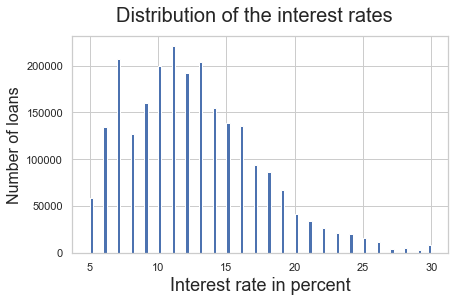

In [21]:
concatenated_df['int_rate'].hist(bins=100)
plt.suptitle('Distribution of the interest rates', fontsize=20)
plt.xlabel('Interest rate in percent', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

### Maturity
Maturity variable is a string in the data set; we need to convert this to numeric.  The information value of the variable is limited because the loans are either 36 or 60 months.  That suggests limited variation in duration and usefulness in credit determination. 

In [22]:
concatenated_df.groupby('term')['term'].count()

term
 36 months    1688183
 60 months     688160
Name: term, dtype: int64

Most loans are relatively medium term of 3 years.

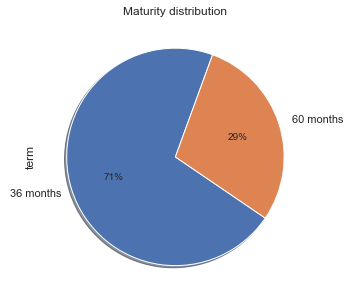

In [23]:
concatenated_df['Maturity'] = [
    int(36) if i == ' 36 months' else int(60) for i in concatenated_df['term']]
concatenated_df['term'].value_counts().plot.pie(figsize=(5, 5), title='Maturity distribution',
                                                shadow=True, startangle=70, autopct='%1.f%%')

### Loan performance
LendingClub offers a detailed breakdown of loan performance.  For us essentially two variables are interesting whether the loan is paid as agreed or not.

There are different approaches to classify loans that are not being paid as agreed.  But, these are U.S. accounting and prudential regulatory requirements.  As far as we are concerned we are only interested in
- Performing loans
- Non-performing loans (loans that are in default)


In [24]:
#default or no-default
concatenated_df['loan_status'].value_counts(ascending=False)

Fully Paid                                             1142001
Current                                                 917478
Charged Off                                             281659
Late (31-120 days)                                       20936
In Grace Period                                           6799
Late (16-30 days)                                         4702
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     19
Name: loan_status, dtype: int64

The target variable that we seek to explain is `PERFORMING`.  Dichotomous classification variable taking the value of 1 for performing or repaid as agreed and 0 for non-performing, modified, charged-off, or in default. 

In [25]:
# creating the endogenous variable / TARGET
concatenated_df['PERFORMING'] = [1 if i == 'Fully Paid' or i ==
                                 'Current' else 0 for i in concatenated_df['loan_status']]
concatenated_df['NON-PERFORMING'] = [0 if i == 'Fully Paid' or i ==
                                     'Current' else 1 for i in concatenated_df['loan_status']]
concatenated_df.groupby('PERFORMING')['PERFORMING'].count()

PERFORMING
0     316899
1    2059479
Name: PERFORMING, dtype: int64

Approximately 14% of the loans go sour.  

In [26]:
concatenated_df['PERFORMING'].describe()

count    2.376378e+06
mean     8.666462e-01
std      3.399568e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: PERFORMING, dtype: float64

Worth looking into loan performance over the time of the portfolio indicates that many loans went sour in early year and then the performance has improved.  I would discount the 2018 and 2019 performance metrics as the loans are too young to go sour.

In [70]:
concatenated_df.groupby(['vintage'])['PERFORMING'].mean()

vintage
2007.0    0.341625
2008.0    0.549519
2009.0    0.780534
2010.0    0.801547
2011.0    0.848211
2012.0    0.838027
2013.0    0.844022
2014.0    0.822641
2015.0    0.813676
2016.0    0.824043
2017.0    0.876067
2018.0    0.947577
2019.0    0.990067
Name: PERFORMING, dtype: float64

### Credit grades
A bit of exploration of the credit grades of the loan portfolio is worth exploring.  I have chosen not to map against the FICO scores, but rather look at the way the loans are scored.  

#### Internal credit grades 
Not surprisingly they tend to be in the good (B) to acceptable (C) category.

In [59]:
concatenated_df['grade'].unique()

array(['B', 'E', 'C', 'D', 'A', 'F', 'G', nan], dtype=object)

In [60]:
concatenated_df = concatenated_df[concatenated_df['grade'].notnull()]

Text(0, 0.5, 'Number of loans')

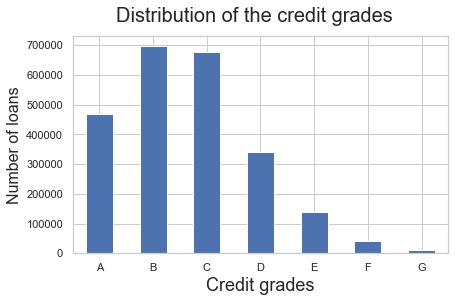

In [61]:
concatenated_df['grade'].value_counts(
)[['A', 'B', 'C', 'D', 'E', 'F', 'G']].plot(kind='bar')
plt.suptitle('Distribution of the credit grades', fontsize=20)
plt.xticks(rotation=0)
plt.xlabel('Credit grades', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

#### Subgrade distribution
The subgrade distribution further confirms a modest risk in the portfolio.  No analysis of changes in the underwriting standards and the credit quality trends is needed. However, it may be interesting to look at the credit scores across loan size bins. 

In [62]:
concatenated_df['sub_grade'].unique()

array(['B5', 'E1', 'C1', 'D2', 'D1', 'B1', 'D4', 'B4', 'D3', 'C2', 'E4',
       'C3', 'C4', 'B3', 'E5', 'B2', 'A1', 'C5', 'A5', 'A3', 'D5', 'A4',
       'E3', 'F5', 'A2', 'E2', 'F4', 'G1', 'G2', 'F1', 'F2', 'F3', 'G4',
       'G3', 'G5'], dtype=object)

In [63]:
concatenated_df = concatenated_df[concatenated_df['sub_grade'].notnull()]

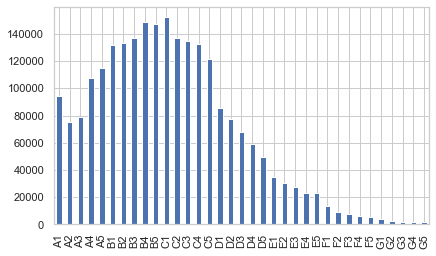

In [64]:
concatenated_df['sub_grade'].value_counts()[[
    'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
    'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5',
    'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5',
    'G1', 'G2', 'G3', 'G4', 'G5']].plot(kind='bar')

#### FICO scores 
Finally considering the credit rating to match up to the risk of the various loans.  Overall, the credit quality normalized to 700 is average,  Considering that 800 is the cut-off for excellent credit and 700 is borderline average, the performance is pretty solid.

In [65]:
concatenated_df['FICO'] = (
    concatenated_df['fico_range_low']+concatenated_df['fico_range_high'])/2
concatenated_df['FICO'].describe()

count    2.376343e+06
mean     7.010052e+02
std      3.316296e+01
min      6.120000e+02
25%      6.770000e+02
50%      6.920000e+02
75%      7.170000e+02
max      8.475000e+02
Name: FICO, dtype: float64

Text(0, 0.5, 'Number of loans')

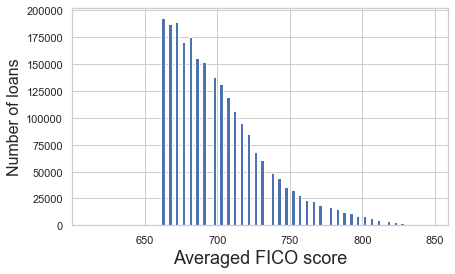

In [66]:
concatenated_df['FICO'].hist(bins=100)
plt.xlabel('Averaged FICO score', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

In [103]:
print(concatenated_df.groupby(['FICO'])['PERFORMING'].mean())

FICO
612.0    0.000000
617.0    0.000000
622.0    0.000000
627.0    0.500000
632.0    0.166667
637.0    0.000000
642.0    0.000000
647.0    0.000000
652.0    0.000000
657.0    0.000000
662.0    0.806589
667.0    0.815050
672.0    0.824576
677.0    0.831468
682.0    0.841160
687.0    0.851875
692.0    0.858913
697.0    0.865685
702.0    0.874994
707.0    0.883877
712.0    0.893190
717.0    0.898770
722.0    0.907039
727.0    0.910754
732.0    0.917107
737.0    0.921849
742.0    0.927584
747.0    0.929234
752.0    0.935225
757.0    0.936540
762.0    0.937190
767.0    0.942929
772.0    0.943815
777.0    0.946129
782.0    0.949508
787.0    0.950008
792.0    0.952707
797.0    0.958585
802.0    0.954090
807.0    0.955730
812.0    0.963767
817.0    0.960699
822.0    0.959415
827.0    0.963629
832.0    0.958495
837.0    0.963974
842.0    0.950331
847.5    0.954262
Name: PERFORMING, dtype: float64


A graph would be nice

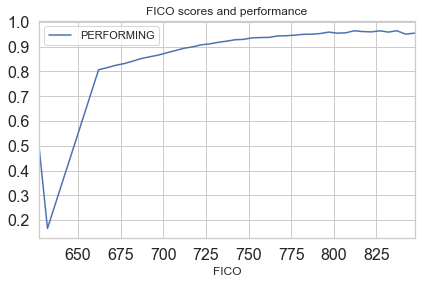

In [107]:
fico_file = concatenated_df.groupby(['FICO'])['PERFORMING'].mean()
fico_file= fico_file[fico_file!=0]
fico_file.plot(kind='line', title = 'FICO scores and performance', legend= True, fontsize=16)


### Employment length 
A classical predictor of loan performance is employment length.  Recent short employment may indicate instability; longer stretch of employment the opposite. 

In [108]:
concatenated_df['emp_length'].describe()

count       2218335
unique           11
top       10+ years
freq         782495
Name: emp_length, dtype: object

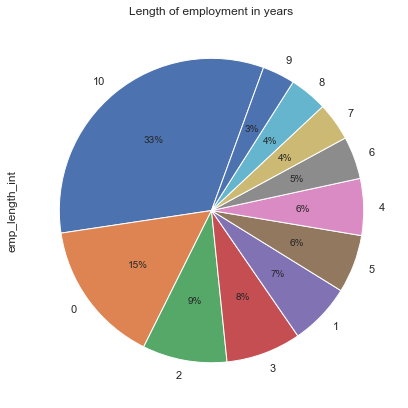

In [109]:
# The employment length variable needs to be convered into digits.
def emp_length_converter(x):
    r = 0
    try:
        r = int(x[:2])
    except:
        pass
    return r


concatenated_df['emp_length_int'] = concatenated_df['emp_length'].apply(
    emp_length_converter)
concatenated_df['emp_length_int'].value_counts().plot.pie(figsize=(7, 7), title='Length of employment in years',
                                                          shadow=False, startangle=70, autopct='%1.f%%')

### Housing
Housing is an additional indicator of stability (owned outright), financial stress (owns with mortgage), or instability in general (rents or other). Creating categorical variables to segregate among the important groups.

In [110]:
concatenated_df['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER'], dtype=object)

In [111]:
concatenated_df.groupby(['home_ownership'])['home_ownership'].count()

home_ownership
ANY            1814
MORTGAGE    1170028
NONE             55
OTHER           182
OWN          266240
RENT         938024
Name: home_ownership, dtype: int64

Clearly variables such as `NONE`, `ANY`, and `OTHER` can be ignored.

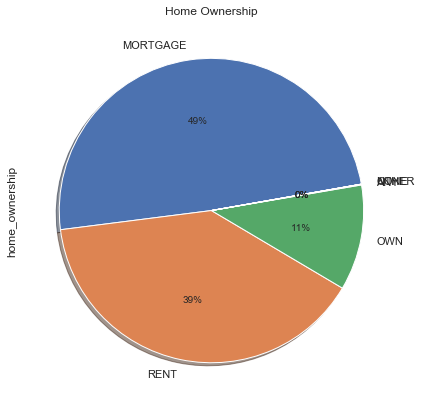

In [112]:
dummy = pd.get_dummies(concatenated_df[['home_ownership']], prefix='home')
home_labels = ['MORTGAGED', 'OWNED', 'RENTED']
concatenated_df = pd.concat([concatenated_df, dummy], axis=1)
concatenated_df['home_ownership'].value_counts().plot.pie(figsize=(7, 7), title='Home Ownership',
                                                          shadow=True, startangle=10, autopct='%1.f%%')

### Annual income
Annual income variable reflects both the ability to sustain and to assume indebtness.  Hence it is essential to include it.  Note, that the mean may be skewed upwards due to some outliers that may or may not be outliers in the sense that they could be borrowers turning to Lending Club with their credit needs.  Removing these outlier observations would skew the distribution downwards.

In [113]:
concatenated_df['annual_inc'].describe()

count    2.376339e+06
mean     7.833614e+04
std      1.125717e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.400000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

Text(0, 0.5, 'Number of loans')

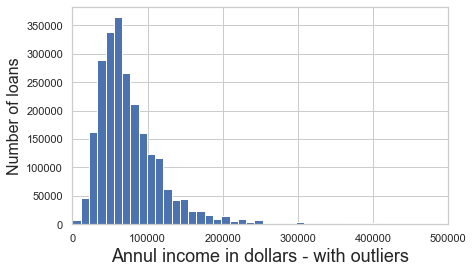

In [118]:
concatenated_df['annual_inc'].hist(bins=10000)
plt.xlabel('Annul income in dollars - with outliers', fontsize=18)
plt.xlim(0, 500000)
plt.ylabel('Number of loans', fontsize=16)

### Credit history
Descriptive statistics for `CREDIT HISTORY`, a variable that implies age.

In [119]:
concatenated_df['CREDIT_HISTORY'].describe()

count    2.376314e+06
mean     1.641087e+01
std      7.699884e+00
min      0.000000e+00
25%      1.100000e+01
50%      1.500000e+01
75%      2.000000e+01
max      8.300000e+01
Name: CREDIT_HISTORY, dtype: float64

Borrowers tend to skew young.

Text(0, 0.5, 'Number of loans')

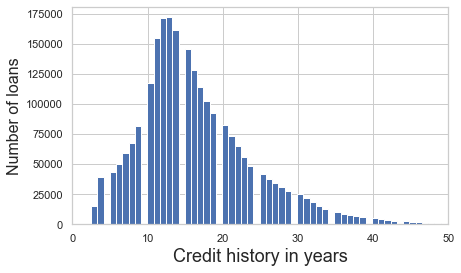

In [120]:
concatenated_df['CREDIT_HISTORY'].hist(bins=100)
plt.xlabel('Credit history in years', fontsize=18)
plt.xlim(0, 50)
plt.ylabel('Number of loans', fontsize=16)

### Debt to income ratio
The debt to income ratio, `dti` is a critical variable to understand and assess because considering with`annual income`, the variable captures the ability to _obtain debt at a point of time_.

In [121]:
concatenated_df['dti'].describe()

count    2.374375e+06
mean     1.890300e+01
std      1.455675e+01
min     -1.000000e+00
25%      1.191000e+01
50%      1.787000e+01
75%      2.455000e+01
max      9.990000e+02
Name: dti, dtype: float64

Text(0, 0.5, 'Number of loans')

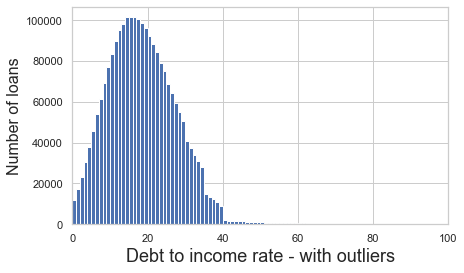

In [126]:
concatenated_df['dti'].hist(bins=1000)
plt.xlabel('Debt to income rate - with outliers', fontsize=18)
plt.xlim(0, 100)
plt.ylabel('Number of loans', fontsize=16)

Keeping the outliers in `dti` makes sense because this could capture some of the highly indebted borrowers with indicators of financial stress.

### Delinquency 
Previous delinquency can presage future delinquency; individuals with a history of delinquency may reoffend at a later stage or are still under ongoing financial pressures that influence negatively repayment.

Text(0, 0.5, 'Number of loans')

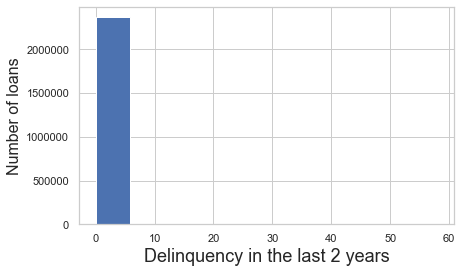

In [127]:
concatenated_df['delinq_2yrs'].hist(bins=10)
plt.xlabel('Delinquency in the last 2 years', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

### Number of accounts
The total number of accounts is total number of credit lines currently in the borrower's credit file, and include both open and closed account.  Generally correlates well with credit history; however the ratio of open and closed accounts should be watched for signs of increased indebtness, which can also be captured by the number of inquiries in the past 6 months or 24 months,depending on the information in the credit files.

In [128]:
concatenated_df['total_acc'].describe()

count    2.376314e+06
mean     2.411186e+01
std      1.199892e+01
min      1.000000e+00
25%      1.500000e+01
50%      2.200000e+01
75%      3.100000e+01
max      1.760000e+02
Name: total_acc, dtype: float64

Text(0, 0.5, 'Number of loans')

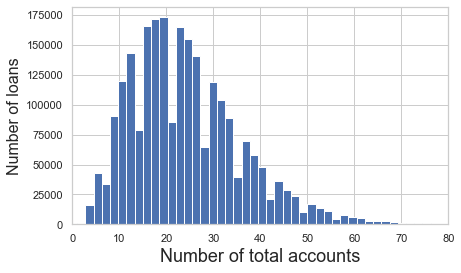

In [129]:
concatenated_df['total_acc'].hist(bins=100)
plt.xlabel('Number of total accounts', fontsize=18)
plt.xlim(0, 80)
plt.ylabel('Number of loans', fontsize=16)

### Number of credit inquiries
The number of credit inquiries in past 6 months (excluding auto and mortgage inquiries) is an indicator of behaviors that suggest that the applicant is actively seeking to shop for credit. While 1 or fewer inquires is normal, multiple inquires is predictably not a positive credit signal. 

In [130]:
concatenated_df.groupby(['inq_last_6mths'])['inq_last_6mths'].count()

inq_last_6mths
0.0     1459385
1.0      612275
2.0      207872
3.0       70967
4.0       17752
5.0        6369
6.0        1231
7.0         195
8.0         122
9.0          50
10.0         24
11.0         15
12.0         15
13.0          6
14.0          6
15.0          9
16.0          3
17.0          2
18.0          4
19.0          2
20.0          1
24.0          2
25.0          1
27.0          1
28.0          1
31.0          1
32.0          1
33.0          1
Name: inq_last_6mths, dtype: int64

Text(0, 0.5, 'Number of loans')

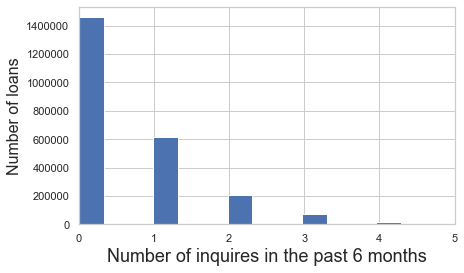

In [131]:
concatenated_df['inq_last_6mths'].hist(bins=100)
plt.xlim([0, 5])
plt.xlabel('Number of inquires in the past 6 months', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

## Loan and performance
Crosstabulating `grade` with `PERFORMING` indicates the general quality of the underwriting process. Considering that 14% of the portfolio is in default, the losses are more prevalent in the D and below category. 

In [132]:
print(concatenated_df.groupby(['grade'])['PERFORMING'].mean())

grade
A    0.962684
B    0.909444
C    0.849181
D    0.787991
E    0.705359
F    0.617748
G    0.572015
Name: PERFORMING, dtype: float64


A more fine crosstabulating of `sub_grade` with `PERFORMING` indicates the general quality of the underwriting process. Considering that 14% of the portfolio is in default, the losses are more prevalent in the D and below category. 

In [133]:
concatenated_df.groupby(['sub_grade'])['PERFORMING'].mean()

sub_grade
A1    0.981291
A2    0.970595
A3    0.965861
A4    0.958465
A5    0.944057
B1    0.931059
B2    0.923791
B3    0.908347
B4    0.900667
B5    0.887000
C1    0.872930
C2    0.858086
C3    0.850749
C4    0.832440
C5    0.825914
D1    0.804581
D2    0.799200
D3    0.788661
D4    0.771344
D5    0.760586
E1    0.725313
E2    0.703246
E3    0.701263
E4    0.691148
E5    0.697250
F1    0.652488
F2    0.615162
F3    0.611831
F4    0.583809
F5    0.581368
G1    0.605884
G2    0.568780
G3    0.556086
G4    0.546145
G5    0.538265
Name: PERFORMING, dtype: float64

The following hard to read graph is essentially the problem with credit underwriting; individuals that have defaulted on debt in the past 2 years can in fact be good credits and individuals who have not may not be good credits.  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


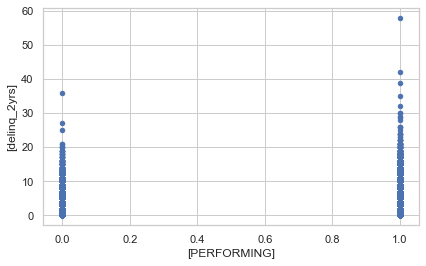

In [134]:
concatenated_df.plot.scatter(['PERFORMING'], ['delinq_2yrs'])
plt.show()

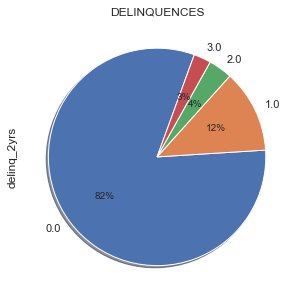

In [135]:
concatenated_df['delinq_2yrs'] = concatenated_df['delinq_2yrs'].map(
    lambda x: x >= 3 and 3 or x)
concatenated_df['delinq_2yrs'] = concatenated_df['delinq_2yrs'].fillna(0)
concatenated_df['delinq_2yrs'].value_counts().plot.pie(figsize=(5, 5), title='DELINQUENCES',
                                                       shadow=True, startangle=70, autopct='%1.f%%')

### Loan purpose
Loan purpose is an important factor to consider. The category provided by the borrower for the loan request is important.  Some are good, such as education and debt consolidation.  Others may be signs of weakness, such as spending or business ventures. 

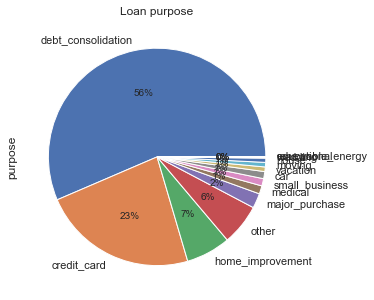

In [136]:
dummy = pd.get_dummies(concatenated_df[['purpose']], prefix='purpose')
purpose_labels = dummy.columns.get_values().tolist()
purpose_labels.remove('purpose_other')
concatenated_df = pd.concat([concatenated_df, dummy], axis=1)
concatenated_df['purpose'].value_counts().plot.pie(figsize=(5, 5), title='Loan purpose',
                                                   autopct='%1.f%%')

### Number of open accounts
The number of open accounts show the number of accounts on file.  Shows the level of indebtedness and the ability to manage multiple credit accounts.  It has to be evaluated in light of the number of total accounts on file, the number of recent credit inquiries and the debt to income ratio.  Additionally, the outstanding balance, particularly the revolving accounts are highly relevant.

count    2.376314e+06
mean     1.161781e+01
std      5.657740e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      1.010000e+02
Name: open_acc, dtype: float64


Text(0, 0.5, 'Number of loans')

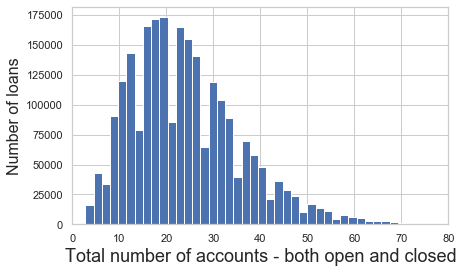

In [137]:
print(concatenated_df['open_acc'].describe())

concatenated_df['total_acc'].hist(bins=100)
plt.xlabel('Total number of accounts - both open and closed', fontsize=18)
plt.xlim(0, 80)
plt.ylabel('Number of loans', fontsize=16)

### Revolving balance
The amount of current credit card and similar debt owed.  The lower, not necessarily the better.  Needs to be evaluated in light of revolving balance utilization.  No outliers removed.

count    2.376343e+06
mean     1.671693e+04
std      2.293945e+04
min      0.000000e+00
25%      5.959000e+03
50%      1.135700e+04
75%      2.032400e+04
max      2.904836e+06
Name: revol_bal, dtype: float64


Text(0, 0.5, 'Number of loans')

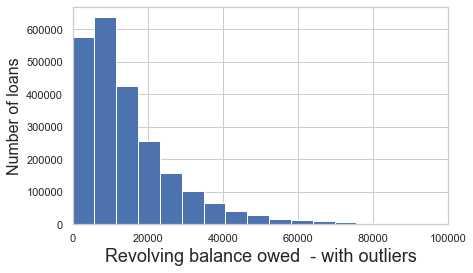

In [138]:
print(concatenated_df['revol_bal'].describe())
concatenated_df['revol_bal'].hist(bins=500)
plt.xlim(0, 100000)
plt.xlabel('Revolving balance owed  - with outliers', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

### Revolving balance utilization
The amount of current credit card and similar debt owed.  The lower, not necessarily the better.  Needs to be evaluated in light of revolving balance levels.  No outliers removed. Note the roundings!

In [139]:
concatenated_df.revol_util = concatenated_df.revol_util.str.extract('(\d+)')
concatenated_df.revol_util = concatenated_df.revol_util.astype('float64')
concatenated_df.revol_util.describe()

count    2.374412e+06
mean     4.961905e+01
std      2.474971e+01
min      0.000000e+00
25%      3.100000e+01
50%      4.900000e+01
75%      6.900000e+01
max      8.920000e+02
Name: revol_util, dtype: float64

count    2.374412e+06
mean     4.961905e+01
std      2.474971e+01
min      0.000000e+00
25%      3.100000e+01
50%      4.900000e+01
75%      6.900000e+01
max      8.920000e+02
Name: revol_util, dtype: float64


Text(0, 0.5, 'Number of loans')

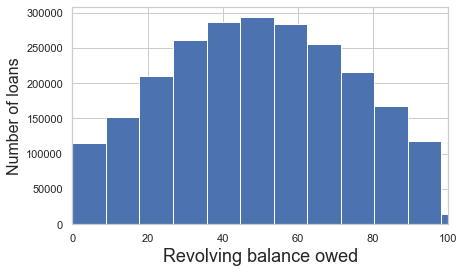

In [140]:
print(concatenated_df['revol_util'].describe())
concatenated_df['revol_util'].hist(bins=100)
plt.xlim(0, 100)
plt.xlabel('Revolving balance owed', fontsize=18)
plt.ylabel('Number of loans', fontsize=16)

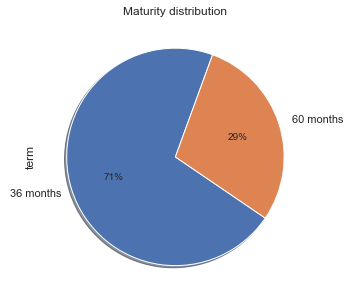

In [141]:
concatenated_df['term'].value_counts().plot.pie(figsize=(5, 5), title='Maturity distribution',
                                                shadow=True, startangle=70, autopct='%1.f%%')

In [142]:
concatenated_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object', length=129)

Housekeeping 

In [143]:
# script to remove any duplicate columns.
def remove_dup_columns(frame):
    keep_names = set()
    keep_icols = list()
    for icol, name in enumerate(frame.columns):
        if name not in keep_names:
            keep_names.add(name)
            keep_icols.append(icol)
    return frame.iloc[:, keep_icols]

In [144]:
concatenated_df = remove_dup_columns(concatenated_df)
concatenated_df = concatenated_df.drop(
    ['member_id', 'policy_code', 'NON-PERFORMING'], axis=1)
concatenated_df.shape

(2376343, 126)

In [151]:
# All columns no renames
concatenated_df = concatenated_df[{'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
                                   'int_rate', 'installment', 'annual_inc',
                                   'dti', 'delinq_2yrs', 'fico_range_low',
                                   'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
                                   'mths_since_last_record', 'open_acc', 'pub_rec',
                                   'revol_bal', 'revol_util', 'total_acc',
                                   'out_prncp', 'out_prncp_inv', 'total_pymnt',
                                   'total_pymnt_inv',
                                   'total_rec_prncp',
                                   'total_rec_int',
                                   'total_rec_late_fee',
                                   'recoveries',
                                   'collection_recovery_fee',
                                   'last_pymnt_amnt',
                                   'last_fico_range_high',
                                   'last_fico_range_low',
                                   'collections_12_mths_ex_med',
                                   'mths_since_last_major_derog',
                                   'acc_now_delinq',
                                   'tot_coll_amt',
                                   'tot_cur_bal',
                                   'open_acc_6m',
                                   'open_act_il',
                                   'open_il_12m',
                                   'open_il_24m',
                                   'mths_since_rcnt_il',
                                   'total_bal_il',
                                   'il_util',
                                   'open_rv_12m',
                                   'open_rv_24m',
                                   'max_bal_bc',
                                   'all_util',
                                   'total_rev_hi_lim',
                                   'total_cu_tl',
                                   'inq_last_12m',
                                   'acc_open_past_24mths',
                                   'avg_cur_bal',
                                   'bc_open_to_buy',
                                   'bc_util',
                                   'chargeoff_within_12_mths',
                                   'delinq_amnt',
                                   'mo_sin_old_il_acct',
                                   'mo_sin_old_rev_tl_op',
                                   'mo_sin_rcnt_rev_tl_op',
                                   'mo_sin_rcnt_tl',
                                   'mort_acc',
                                   'mths_since_recent_bc',
                                   'mths_since_recent_bc_dlq',
                                   'mths_since_recent_inq',
                                   'mths_since_recent_revol_delinq',
                                   'num_accts_ever_120_pd',
                                   'num_actv_bc_tl',
                                   'num_actv_rev_tl',
                                   'num_bc_sats',
                                   'num_bc_tl',
                                   'num_il_tl',
                                   'num_op_rev_tl',
                                   'num_rev_accts',
                                   'vintage',
                                   'last_pmt_year',
                                   'CREDIT_HISTORY',
                                   'Maturity',
                                   'emp_length_int',
                                   'PERFORMING', 'purpose', 'home_ownership'}]

# Correlations
Understanding the correlation structure among variables is essential, particularly in relation with performance variables.

In [153]:
correlation_m = concatenated_df.corr()
a = correlation_m.sum()

PERFORMING                 1.000000
last_fico_range_high       0.611392
last_fico_range_low        0.558014
total_rec_prncp            0.229804
last_pmt_year              0.228001
last_pymnt_amnt            0.191082
out_prncp                  0.163213
out_prncp_inv              0.163195
total_pymnt_inv            0.141924
total_pymnt                0.141236
vintage                    0.135021
fico_range_low             0.122999
fico_range_high            0.122998
bc_open_to_buy             0.082873
mths_since_recent_inq      0.062365
total_rev_hi_lim           0.058534
avg_cur_bal                0.057349
mo_sin_rcnt_rev_tl_op      0.054945
mo_sin_rcnt_tl             0.054873
tot_cur_bal                0.053737
mths_since_recent_bc       0.048019
max_bal_bc                 0.040930
mort_acc                   0.040020
mo_sin_old_rev_tl_op       0.037894
mths_since_last_record     0.035040
CREDIT_HISTORY             0.032862
mths_since_rcnt_il         0.028775
annual_inc                 0

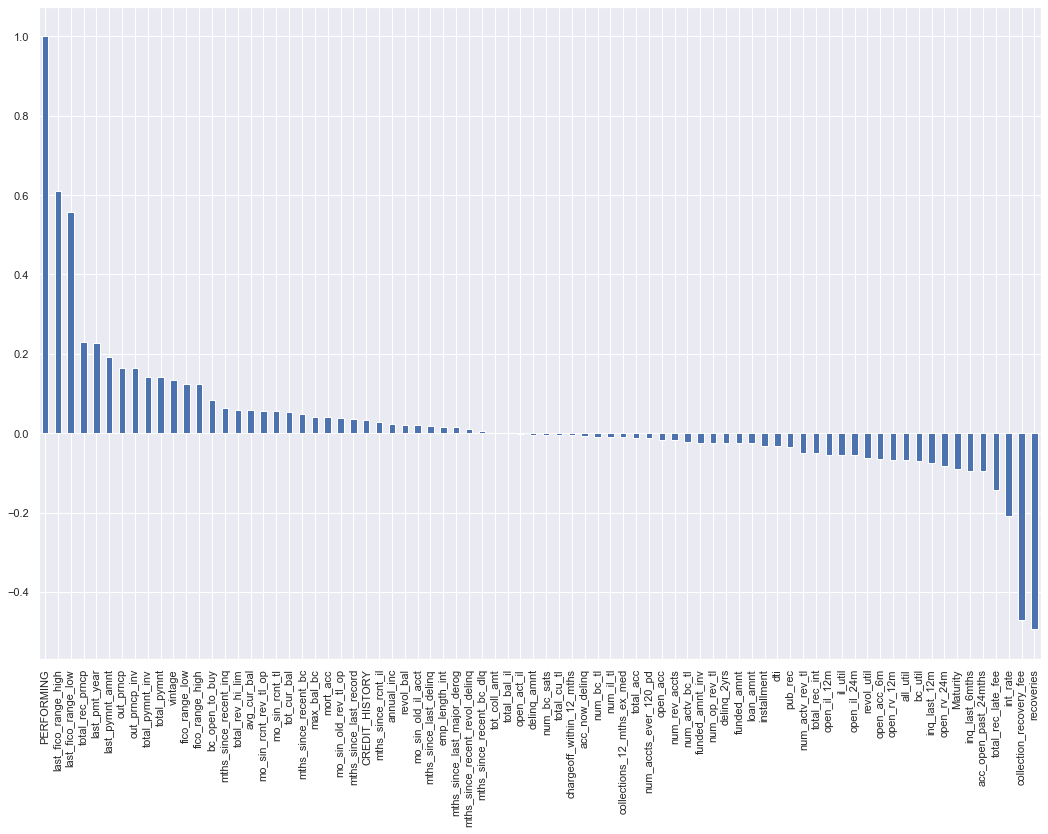

In [156]:
print(correlation_m["PERFORMING"].sort_values(ascending=False))

correlation_m["PERFORMING"].sort_values(ascending=False).plot(kind='bar', figsize=(16,12))

### Dendogram
Clustering reveals variables that are cooridnated. 

Text(0.5, 0.98, 'Dendogram all observations')

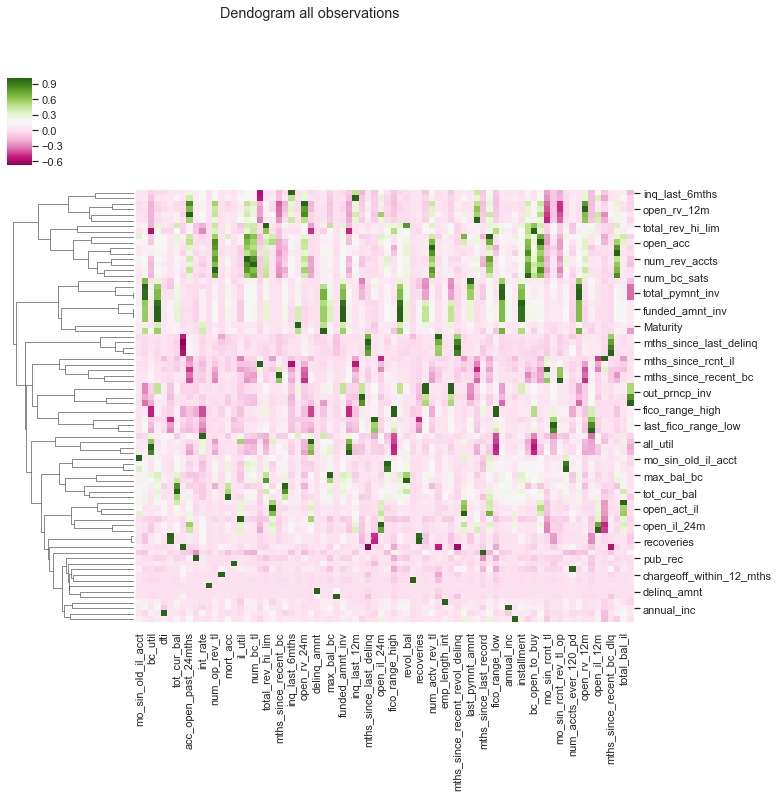

In [157]:
g2 = sns.clustermap(correlation_m, method='average', metric='euclidean',
                    row_cluster=True, col_cluster=False, cmap="PiYG")
sns.set(rc={'figure.figsize': (12, 9)})
g2.fig.suptitle('Dendogram all observations')

### Correlation heatmap
Heatmap of some of the more important variables

Text(0.5, 0.98, 'Clustermap all observations')

<Figure size 720x720 with 0 Axes>

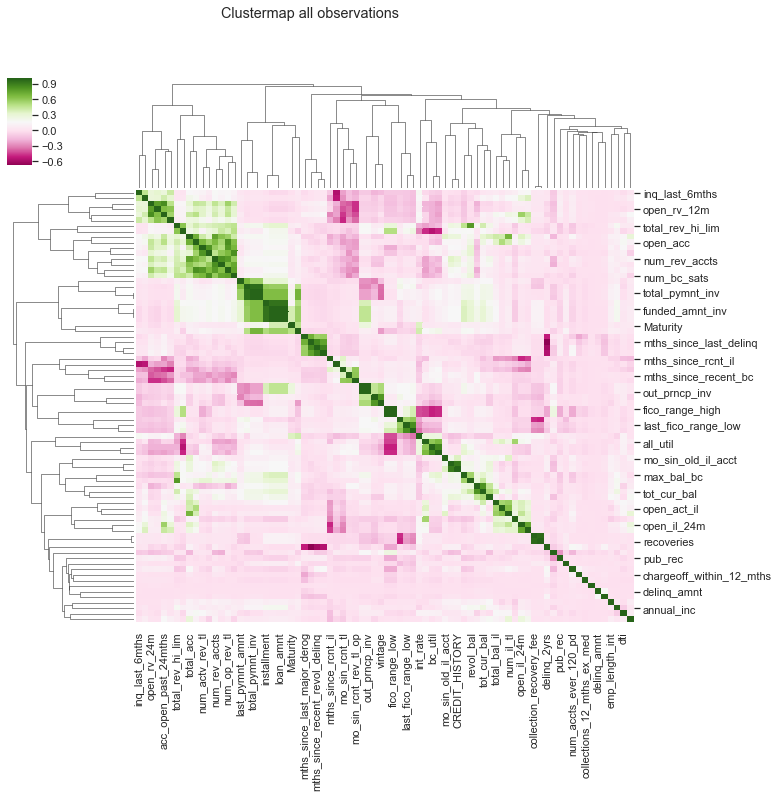

In [158]:
plt.figure(figsize=(10, 10))

g1 = sns.clustermap(correlation_m, method='average', metric='euclidean',
                    row_cluster=True, col_cluster=True, cmap="PiYG")
g1.fig.suptitle('Clustermap all observations')

There are some spots of high correlation between revolving balance usage, number of accounts, the periods surrounding delinquency, and also balance carried forward.  Hence, the old adage that lot of credit utilization is not a good sign holds.

The results are not surprising:  _variables that are indicating creditability are inversely correlated with default_.  The question now is which of these variables should we model.  Should we take all the variables and overspecify the model or carefully cull the variables to extract those variables that are contain the highest potential explanatory value.  

The approach I chose is decision trees and random forest to understand the various relationships and to explore the relative value between the various variables.  That is the next file.

# Housekeeping
The last piece is to save the variables that we need for further processing in the next workbooks.

In [ ]:
concatenated_df = remove_dup_columns(concatenated_df)
print("The saved file has observations and variables of", concatenated_df.shape, "respectively")

This is a huge file downloaded -- close to 1GB.

In [160]:
# save step
concatenated_df.to_csv('data/full_data.csv')

In [ ]:
# ENDS # ENDS # ENDS
#########################################################################################
# ENDS ####### (c) Peter Went, 2019
#########################################################################################